In [93]:
### Learning of the surface
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

# load the pickle file
with open('./simulation_results/results_panwa_2.pkl', 'rb') as f:
    data = pickle.load(f) 

In [94]:
# Extract data from all entries in the list
flash_pressures = []
heater_temperatures = []
benzene_purity_vapor = []
toluene_purity_vapor = []
benzene_purity_liquid = []
toluene_purity_liquid = []

# Loop through all 400 data points
for entry in data:
    flash_pressures.append(entry['Pressure Flash'])
    heater_temperatures.append(entry['HeaterInputs']['Temperature'])
    
    # Extract mole fractions in vapor and liquid phase
    vapor_mole_frac = entry['VaporOutputs']['MoleFracList']
    liquid_mole_frac = entry['LiquidOutputs']['MoleFracList']

    benzene_purity_vapor.append(vapor_mole_frac[0])
    toluene_purity_vapor.append(vapor_mole_frac[1])
    benzene_purity_liquid.append(liquid_mole_frac[0])
    toluene_purity_liquid.append(liquid_mole_frac[1])

# Create DataFrame
purity_trends = pd.DataFrame({
    'Flash Pressure (bar)': flash_pressures,
    'Heater Temperature (°C)': heater_temperatures,
    'Benzene Purity (Vapor)': benzene_purity_vapor,
    'Toluene Purity (Vapor)': toluene_purity_vapor,
    'Benzene Purity (Liquid)': benzene_purity_liquid,
    'Toluene Purity (Liquid)': toluene_purity_liquid
})

In [95]:
# I only want flash_pressures, heater_temperatures, and benzene_purity_vapor
X = purity_trends[['Flash Pressure (bar)', 'Heater Temperature (°C)']]
y = purity_trends['Benzene Purity (Vapor)']

print(X.shape)
print(X)
print(y.shape)
print(y)


(3600, 2)
      Flash Pressure (bar)  Heater Temperature (°C)
0                 0.100000                      0.0
1                 0.267797                      0.0
2                 0.435593                      0.0
3                 0.603390                      0.0
4                 0.771186                      0.0
...                    ...                      ...
3595              9.328814                    220.0
3596              9.496610                    220.0
3597              9.664407                    220.0
3598              9.832203                    220.0
3599             10.000000                    220.0

[3600 rows x 2 columns]
(3600,)
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3595    0.5
3596    0.5
3597    0.5
3598    0.5
3599    0.5
Name: Benzene Purity (Vapor), Length: 3600, dtype: float64


In [96]:
import torch
from torch import nn

class RSModel(nn.Module):
    def __init__(self, dropout_prob=0.5):  # Set dropout probability (default: 50%)
        super(RSModel, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2, 128))
        self.layers.append(nn.Linear(128, 256))
        self.layers.append(nn.Linear(256, 512))
        self.layers.append(nn.Linear(512, 256))
        self.layers.append(nn.Linear(256, 128))
        self.layers.append(nn.Linear(128, 1))
        self.relu = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout layer

        # Initialize weights
        for layer in self.layers:
            nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
            x = self.relu(x)
            x = self.dropout(x)  # Apply dropout after activation
        x = self.layers[-1](x)
        x = nn.Sigmoid()(x)
        return x


In [97]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1) 
batch_size = 256


# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalize the data using Min-Max scaling
X_train_min = X_train.min(dim=0)[0]
print("X_train_min:", X_train_min)
X_train_max = X_train.max(dim=0)[0]
print("X_train_max:", X_train_max)
X_train_normalized = (X_train - X_train_min) / (X_train_max - X_train_min)
X_val_normalized = (X_val - X_train_min) / (X_train_max - X_train_min)
X_test_normalized = (X_test - X_train_min) / (X_train_max - X_train_min)
print("X_train_normalized_min:", X_train_normalized.min(dim=0)[0])
print("X_train_normalized_max:", X_train_normalized.max(dim=0)[0])


#CHecking min max for y_train, y_val, y_test
y_train_min = y_train.min(dim=0)[0]
print("y_train_min:", y_train_min)
y_train_max = y_train.max(dim=0)[0]
print("y_train_max:", y_train_max)

y_val_min = y_val.min(dim=0)[0]
print("y_val_min:", y_val_min)
y_val_max = y_val.max(dim=0)[0]
print("y_val_max:", y_val_max)


# Create DataLoader for training, validation, and test sets
train_dataset = TensorDataset(X_train_normalized, y_train)
val_dataset = TensorDataset(X_val_normalized, y_val)
test_dataset = TensorDataset(X_test_normalized, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X_train_min: tensor([0.1000, 0.0000])
X_train_max: tensor([ 10., 220.])
X_train_normalized_min: tensor([0., 0.])
X_train_normalized_max: tensor([1., 1.])
y_train_min: tensor([0.])
y_train_max: tensor([0.7721])
y_val_min: tensor([0.])
y_val_max: tensor([0.7155])


In [98]:
# # Use box-cox transformation to transform the target variable
# from scipy.stats import boxcox
# y_train, y_val, y_test = y_train.squeeze(), y_val.squeeze(), y_test.squeeze()
# print(y_train.shape)
# print(y_train.min(), y_train.max()) 
# y_train_boxcox, lam = boxcox(y_train + 1e-6)  # Adding a small value to avoid zero
# y_val_boxcox = boxcox(y_val, lam)
# y_test_boxcox = boxcox(y_test, lam)



torch.Size([2520, 2])


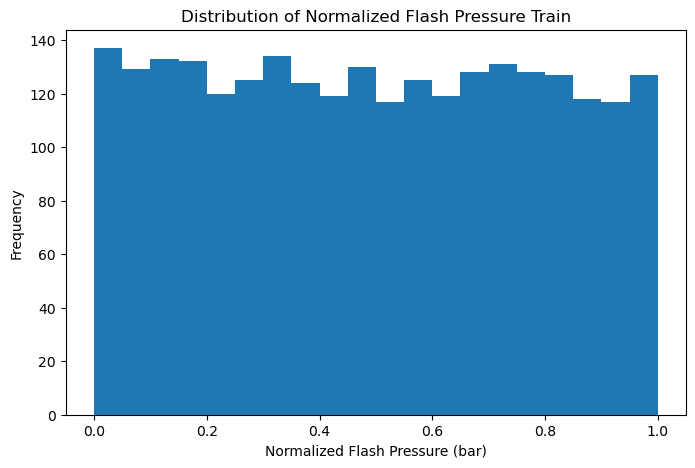

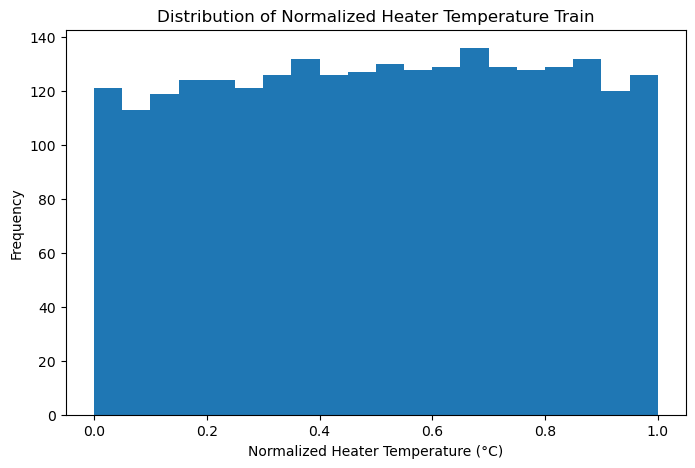

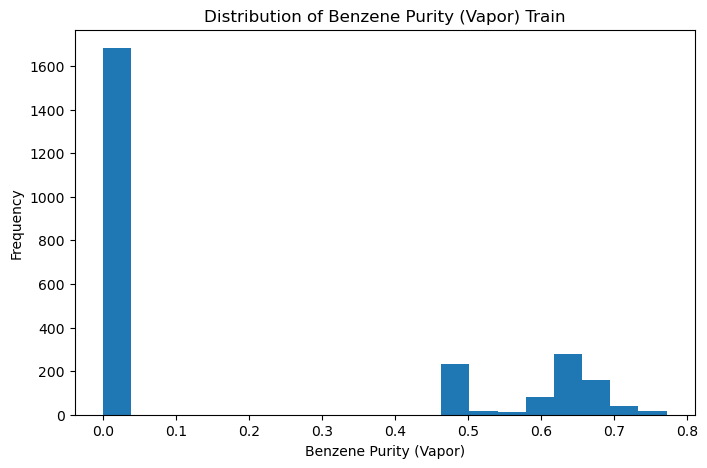

In [99]:
# Plot the distribution of training data
print(X_train_normalized.shape)

# Plot distribution of the temperature, first column
plt.figure(figsize=(8, 5))
plt.hist(X_train_normalized[:, 0].numpy(), bins=20)
plt.xlabel('Normalized Flash Pressure (bar)')
plt.ylabel('Frequency')
plt.title('Distribution of Normalized Flash Pressure Train')
plt.show()

# Plot distribution of the pressure, second column
plt.figure(figsize=(8, 5))
plt.hist(X_train_normalized[:, 1].numpy(), bins=20)
plt.xlabel('Normalized Heater Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Distribution of Normalized Heater Temperature Train')
plt.show()

# Plot distribution of the purity, target column
plt.figure(figsize=(8, 5))
plt.hist(y_train.numpy(), bins=20)
plt.xlabel('Benzene Purity (Vapor)')
plt.ylabel('Frequency')
plt.title('Distribution of Benzene Purity (Vapor) Train')
plt.show()

In [100]:
# Training loop with loss tracking
model = RSModel(dropout_prob=0.5)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

n_epochs = 200
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for i, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_dataloader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
        val_loss /= len(val_dataloader)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


Epoch 10/200, Train Loss: 0.0372, Val Loss: 0.0112
Epoch 20/200, Train Loss: 0.0222, Val Loss: 0.0075
Epoch 30/200, Train Loss: 0.0188, Val Loss: 0.0077
Epoch 40/200, Train Loss: 0.0151, Val Loss: 0.0079
Epoch 50/200, Train Loss: 0.0139, Val Loss: 0.0042
Epoch 60/200, Train Loss: 0.0127, Val Loss: 0.0033
Epoch 70/200, Train Loss: 0.0111, Val Loss: 0.0063
Epoch 80/200, Train Loss: 0.0107, Val Loss: 0.0036
Epoch 90/200, Train Loss: 0.0108, Val Loss: 0.0046
Epoch 100/200, Train Loss: 0.0103, Val Loss: 0.0052
Epoch 110/200, Train Loss: 0.0118, Val Loss: 0.0062
Epoch 120/200, Train Loss: 0.0101, Val Loss: 0.0042
Epoch 130/200, Train Loss: 0.0086, Val Loss: 0.0029
Epoch 140/200, Train Loss: 0.0089, Val Loss: 0.0027
Epoch 150/200, Train Loss: 0.0096, Val Loss: 0.0040
Epoch 160/200, Train Loss: 0.0090, Val Loss: 0.0041
Epoch 170/200, Train Loss: 0.0083, Val Loss: 0.0034
Epoch 180/200, Train Loss: 0.0083, Val Loss: 0.0038
Epoch 190/200, Train Loss: 0.0103, Val Loss: 0.0032
Epoch 200/200, Train 

Text(0, 0.5, 'Frequency')

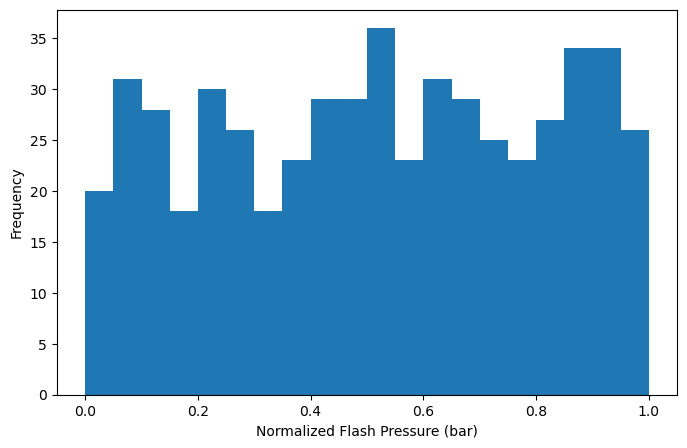

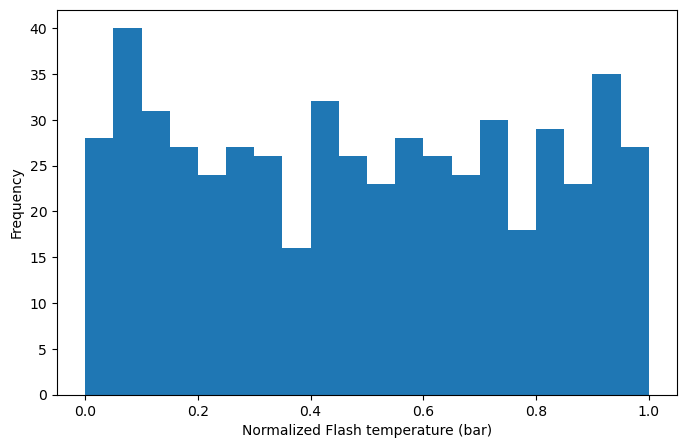

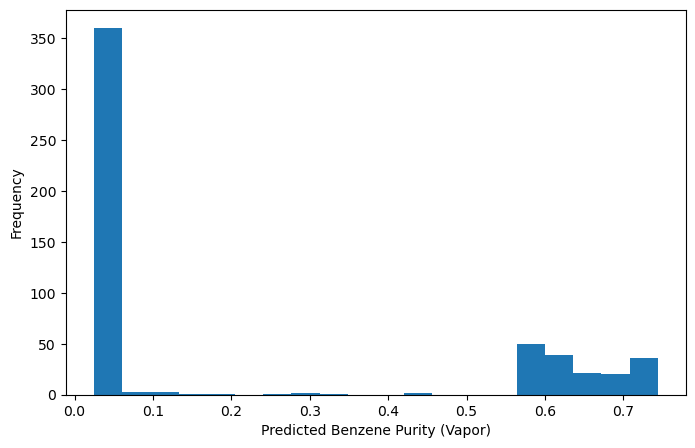

In [101]:
# Look at output distribution on the validation set
model.eval()
y_val_pred = []
with torch.no_grad():
    for X_batch, y_batch in val_dataloader:
        y_pred = model(X_batch)
        y_val_pred.extend(y_pred.numpy())
y_val_pred = np.array(y_val_pred)

#Plot the distribution of pressure
plt.figure(figsize=(8, 5))
plt.hist(X_val_normalized[:, 0].numpy(), bins=20)
plt.xlabel('Normalized Flash Pressure (bar)')
plt.ylabel('Frequency')

#Plot the distribution of temperature
plt.figure(figsize=(8, 5))
plt.hist(X_val_normalized[:, 1].numpy(), bins=20)
plt.xlabel('Normalized Flash temperature (bar)')
plt.ylabel('Frequency')

# Plot the distribution of the predicted purity
plt.figure(figsize=(8, 5))
plt.hist(y_val_pred, bins=20)
plt.xlabel('Predicted Benzene Purity (Vapor)')
plt.ylabel('Frequency')


0.02484442 0.75470203


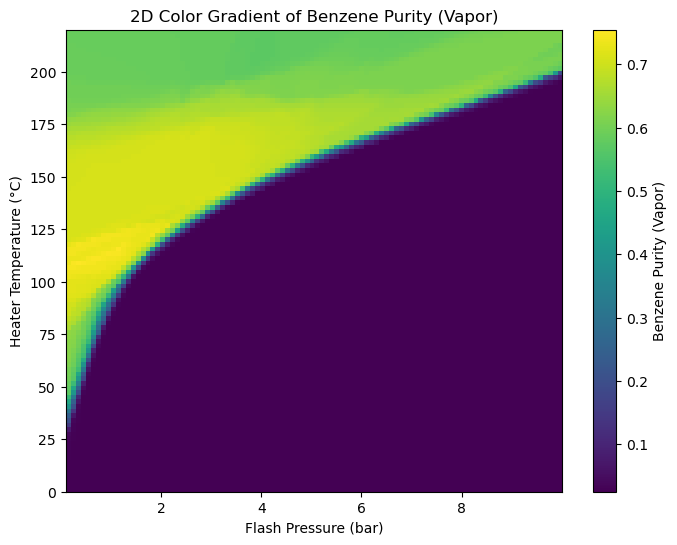

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Ensure model is in evaluation mode
model.eval()

# Generate a grid of points to evaluate the model
n_points = 100
flash_pressure = np.linspace(0, 1, n_points)
heater_temperature = np.linspace(0, 1, n_points)
flash_pressure_grid, heater_temperature_grid = np.meshgrid(flash_pressure, heater_temperature)
X_grid = np.c_[flash_pressure_grid.ravel(), heater_temperature_grid.ravel()]
X_grid_tensor = torch.tensor(X_grid, dtype=torch.float32)

# Evaluation loop
y_grid_pred = []
with torch.no_grad():
    for X_batch in torch.split(X_grid_tensor, batch_size):
        y_pred = model(X_batch)
        y_grid_pred.extend(y_pred.numpy())

# Unnormalize the data
X_train_min = X_train.min(dim=0)[0].numpy()
X_train_max = X_train.max(dim=0)[0].numpy()

# Undo min-max scaling on X
X_grid[:, 0] = X_grid[:, 0] * (X_train_max[0] - X_train_min[0]) + X_train_min[0]
X_grid[:, 1] = X_grid[:, 1] * (X_train_max[1] - X_train_min[1]) + X_train_min[1]

y_grid_pred = np.array(y_grid_pred)  # Convert list to numpy array
print(y_grid_pred.min(), y_grid_pred.max()) 

# Reshape predictions to match grid shape
y_grid_pred = y_grid_pred.reshape(n_points, n_points)

# Correct extent using unnormalized X values
plt.figure(figsize=(8, 6))
plt.imshow(
    y_grid_pred,
    extent=[X_grid[:, 0].min(), X_grid[:, 0].max(), X_grid[:, 1].min(), X_grid[:, 1].max()],
    origin='lower',
    cmap='viridis',
    aspect='auto'
)
plt.colorbar(label="Benzene Purity (Vapor)")
plt.xlabel('Flash Pressure (bar)')
plt.ylabel('Heater Temperature (°C)')
plt.title('2D Color Gradient of Benzene Purity (Vapor)')
plt.show()
